In [3]:
# Install pandas and pyarrow, which is libraries that enable reading of parquet files
pip install pandas pyarrow

Note: you may need to restart the kernel to use updated packages.


## Data Overview <a class="anchor"  id="data_overview"></a>

In [2]:
# Import necessary modules
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

pd.set_option('display.max_columns', None)

In [3]:
# Reading the credit card users data
users = pd.read_parquet('credit_card_users_de.parquet')

# Reading the credit card details data
cards = pd.read_parquet('sd254_cards_de.parquet')

# Reading the credit card transaction data
transactions = pd.read_parquet('credit_card_transaction_data_de.parquet')

#### Preview datasets

In [165]:
users.head()

,User,Current Age,Retirement Age,Gender,State,Num Credit Cards
0,0,53,66,Female,CA,5
1,1,53,68,Female,NY,5
2,2,81,67,Female,CA,5
3,3,63,63,Female,NY,4
4,4,43,70,Male,CA,1


In [4]:
# Remove personal and uncessary features from users data

users.drop(columns=['Person','Birth Year','Address','Apartment','City','Zipcode','Birth Month',
                    'Per Capita Income - Zipcode','Yearly Income - Person',
                    'Total Debt','FICO Score', 'Latitude', 'Longitude'],inplace=True, axis=1)
users = users.reset_index().rename({'index':'User'},axis=1)

In [172]:
cards.head()

,User,Card Brand,Card Type,Has Chip,Cards Issued,Credit Limit
0,0,Visa,Debit,YES,2,$24295
1,0,Visa,Debit,YES,2,$21968
2,0,Visa,Debit,YES,2,$46414
3,0,Visa,Credit,NO,1,$12400
4,0,Mastercard,Debit (Prepaid),YES,1,$28


In [267]:
#There is only one value in Card on Dark Web column, so we can drop this feature

cards['Card on Dark Web'].value_counts()

No    6146
Name: Card on Dark Web, dtype: int64

In [268]:
# Remove personal and uncessary features from cards data

cards.drop(columns=['Card Number','Expires','CVV','Year PIN last Changed',
                    'Acct Open Date','Card on Dark Web'],inplace=True, axis=1)

In [159]:
transactions.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
4136,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,CA,91750.0,7538,None,No
4137,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,None,No
4138,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,CA,91750.0,7538,None,No
4139,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No
4140,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,None,No


In [269]:
# Merge users,cards and transactions data

df = pd.merge(transactions, cards, left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'], how='left')
df = pd.merge(df, users, left_on=['User'], right_on=['User'], how='left')
del transactions, cards, users
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6877837 entries, 0 to 6877836
Data columns (total 26 columns):
 #   Column            Dtype  
---  ------            -----  
 0   User              int64  
 1   Card              int64  
 2   Year              int64  
 3   Month             int64  
 4   Day               int64  
 5   Time              object 
 6   Amount            object 
 7   Use Chip          object 
 8   Merchant Name     int64  
 9   Merchant City     object 
 10  Merchant State    object 
 11  Zip               float64
 12  MCC               int64  
 13  Errors?           object 
 14  Is Fraud?         object 
 15  CARD INDEX        int64  
 16  Card Brand        object 
 17  Card Type         object 
 18  Has Chip          object 
 19  Cards Issued      int64  
 20  Credit Limit      object 
 21  Current Age       int64  
 22  Retirement Age    int64  
 23  Gender            object 
 24  State             object 
 25  Num Credit Cards  int64  
dtypes: float64(1),

In [270]:
# Remove personal and uncessary features 

df.drop(columns=['Card','CARD INDEX',"Zip"],inplace=True, axis=1)

In [181]:
df.head()

,User,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MCC,Errors?,Is Fraud?,Card Brand,Card Type,Has Chip,Cards Issued,Credit Limit,Current Age,Retirement Age,Gender,State,Num Credit Cards
0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,CA,7538,None,No,Visa,Debit,YES,2,$24295,53,66,Female,CA,5
1,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,CA,5912,None,No,Visa,Debit,YES,2,$24295,53,66,Female,CA,5
2,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,CA,7538,None,No,Visa,Debit,YES,2,$24295,53,66,Female,CA,5
3,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,CA,5651,None,No,Visa,Debit,YES,2,$24295,53,66,Female,CA,5
4,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,CA,5942,None,No,Visa,Debit,YES,2,$24295,53,66,Female,CA,5


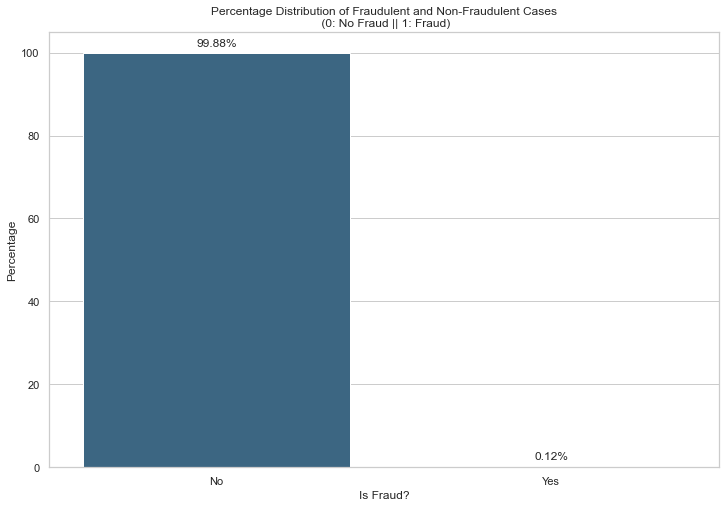

In [271]:
# Check the number of fraudulent transactions
value_counts = df['Is Fraud?'].value_counts()

# Calculate percentage values
percentage_values = (value_counts / value_counts.sum()) * 100

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(x=percentage_values.index, y=percentage_values.values, palette="viridis")

# Adding labels and title
plt.xlabel('Is Fraud?')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Fraudulent and Non-Fraudulent Cases\n (0: No Fraud || 1: Fraud)')

# Annotate each bar with the percentage value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()

The data is imbalance. Most of the transactions were Non-Fraud (99.87%) of the time, while Fraud transactions occurs (0.12%) of the time in the dataframe.

In [186]:
# Check missing value by column
df.isnull().sum()

User                      0
Year                      0
Month                     0
Day                       0
Time                      0
Amount                    0
Use Chip                  0
Merchant Name             0
Merchant City             0
Merchant State       860764
MCC                       0
Errors?             6768768
Is Fraud?                 0
Card Brand                0
Card Type                 0
Has Chip                  0
Cards Issued              0
Credit Limit              0
Current Age               0
Retirement Age            0
Gender                    0
State                     0
Num Credit Cards          0
dtype: int64

## Data Cleaning <a class="anchor"  id="data_overview"></a>

In [272]:
# We need to strip the '$' from the Amount and Credit Limit to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)
df["Credit Limit"]=df["Credit Limit"].str.replace("$","").astype(float)

/var/folders/2r/yg0nprg96sbgd961y4crt5lm0000gq/T/ipykernel_57454/420437335.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Amount"]=df["Amount"].str.replace("$","").astype(float)
/var/folders/2r/yg0nprg96sbgd961y4crt5lm0000gq/T/ipykernel_57454/420437335.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Credit Limit"]=df["Credit Limit"].str.replace("$","").astype(float)


In [273]:
# Extract the hour and minute to perform a more refined time series analysis
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]
df = df.drop(['Time'],axis=1)

In [274]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

## Exploratory Data Analysis <a class="anchor"  id="eda"></a>

To gain relevant insights into fraud cases, We subset this group of data for Exploratory Data Analysis. This targeted approach allows for a more in-depth analysis and understanding of the underlying patterns and behaviors associated with fraud.

In [275]:
fraud_data = df[df['Is Fraud?'] == 1]

#### Transaction Amount

/Users/laura.le/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


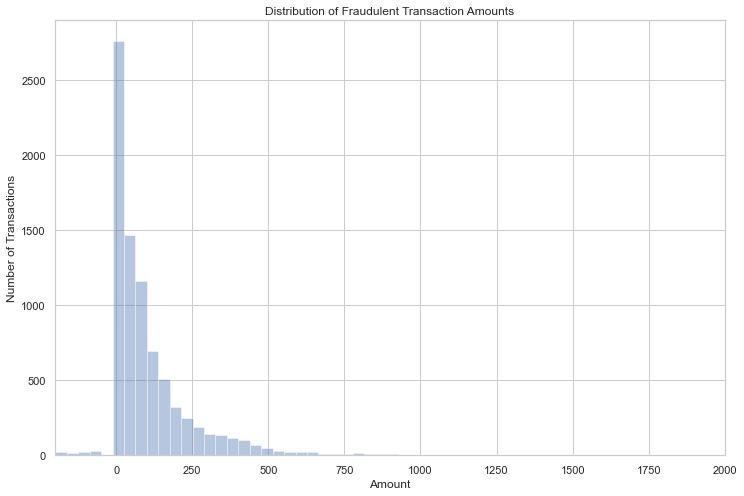

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.distplot(fraud_data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()

The majority of fraudulent transactions' amount range from 0 to 250, indicating a prevalence of fraud in smaller-value transactions.

#### Geographical Distribution

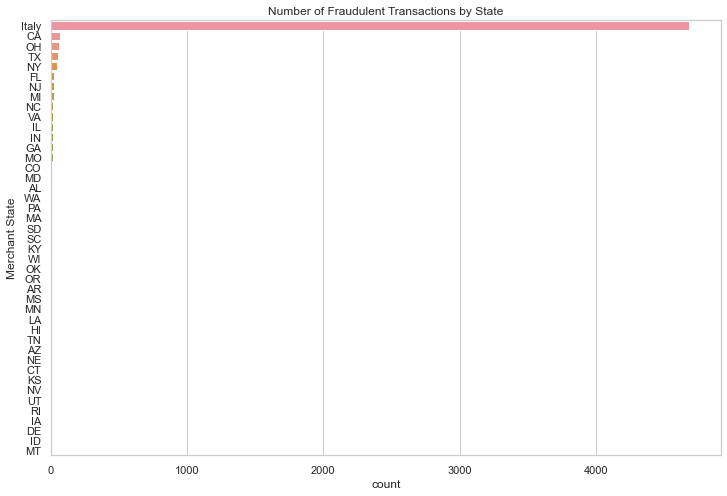

In [217]:
plt.figure(figsize=(12, 8))  
sns.countplot(data=fraud_data, y='Merchant State', order=fraud_data['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

The data contains a mix of US states and other countries, highlighting clear geographical distinctions.

- At the country level, Italy is the major hotspot for fraudulent activities. 
- Among US states, California, Ohio, Texas, and New York records the highest incidences of fraud.

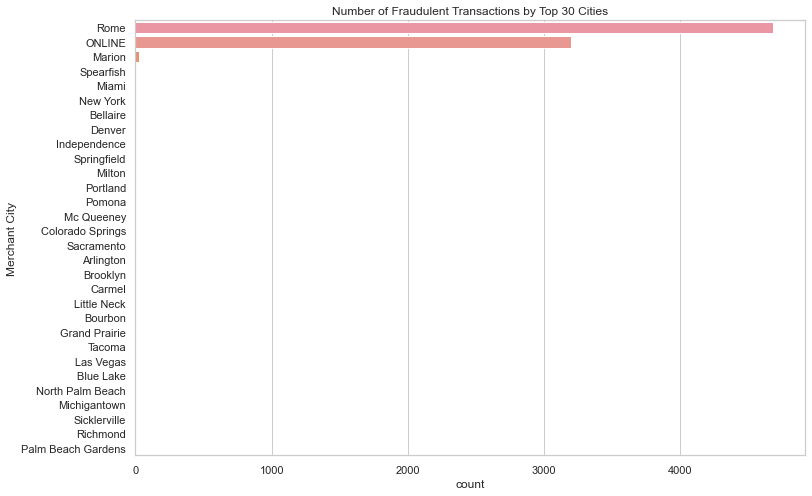

In [220]:
plt.figure(figsize=(12, 8))
top_cities = fraud_data['Merchant City'].value_counts().head(30).index
sns.countplot(data=fraud_data, y='Merchant City', order=top_cities)
plt.title('Number of Fraudulent Transactions by Top 30 Cities')
plt.show()

Online transactions are the primary venues where fraud predominantly occurs. Additionally, cities such as Rome, and Marion are notable hotspots for high frequencies of fraudulent activities.

#### Time Variation 

##### By year

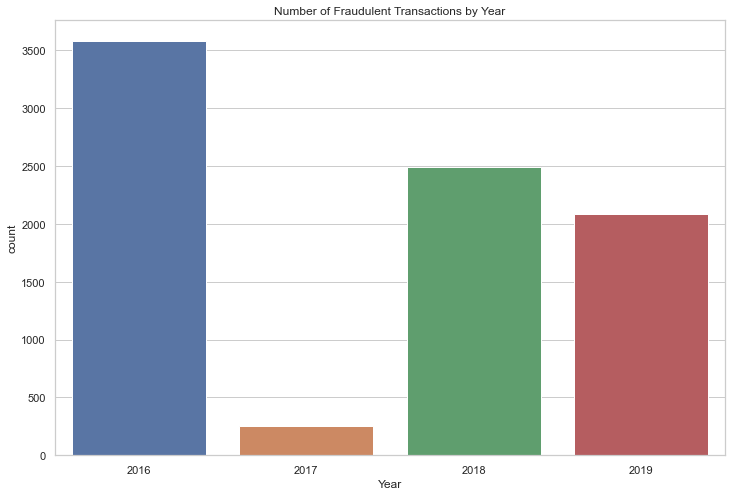

In [221]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Year')
plt.title('Number of Fraudulent Transactions by Year')
plt.show()

The trend of fraudulent transaction indicates a significant peak in 2016, followed by a sharp decrease in 2017 and then it rises again but remains lower than the 2016 level.

##### By month

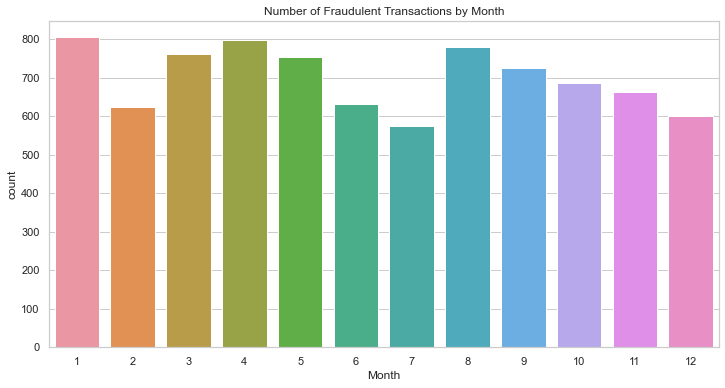

In [223]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='Month')
plt.title('Number of Fraudulent Transactions by Month')
plt.show()

The chart suggests a pattern where fraudulent transactions peak at the beginning of the year, decrease towards the middle, rise again in late summer and early fall, and then decrease towards the end of the year

##### By day of month

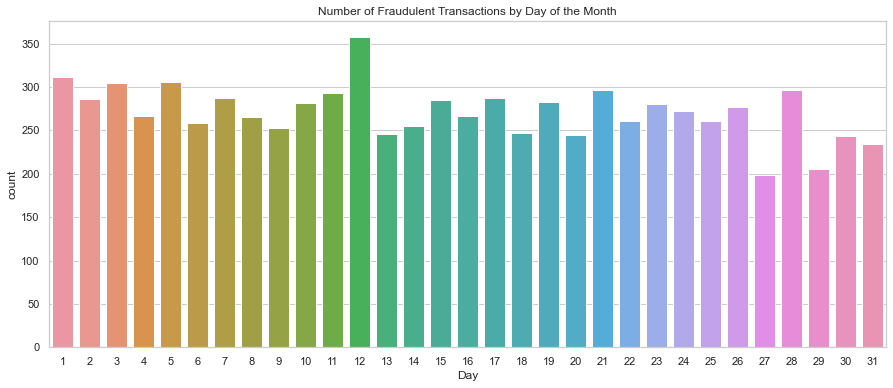

In [224]:
plt.figure(figsize=(15, 6))
sns.countplot(data=fraud_data, x='Day')
plt.title('Number of Fraudulent Transactions by Day of the Month')
plt.show()

The data indicates that fraudulent activities are not evenly spread across the month and seem to follow a pattern where certain days are more prone to fraud.

##### By day of week

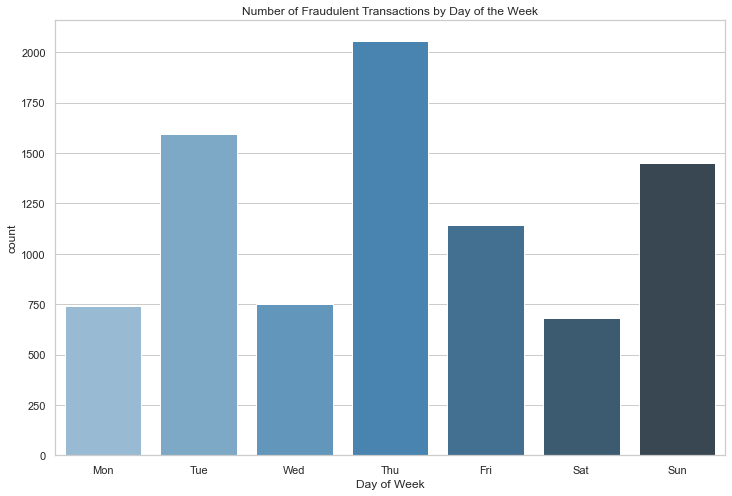

In [292]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

fraud_data = df[df['Is Fraud?'] == 1]

# Visualize
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Blues_d")
plt.title('Number of Fraudulent Transactions by Day of the Week')
plt.show()


The data reveals a weekly pattern in fraud, peaking on Thursdays and dipping over the weekend. Financial institutions might benefit from bolstering fraud defenses mid-week and scaling back on lower-risk days such as Sunday. 

##### By hour of day

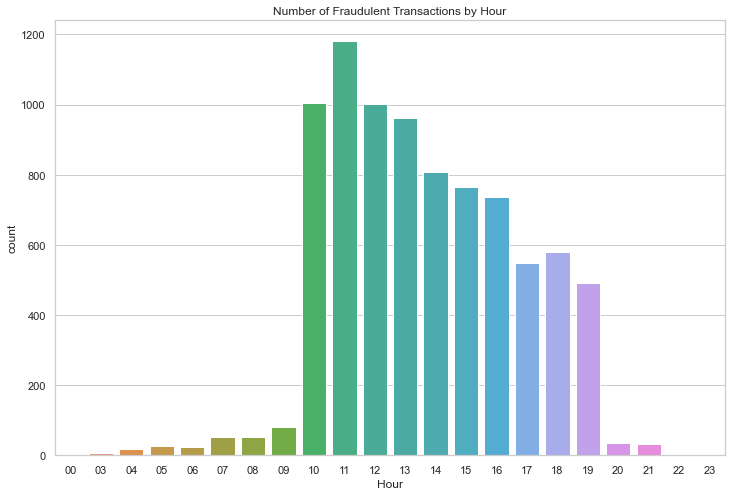

In [230]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Hour', order=sorted(fraud_data['Hour'].unique()))
plt.title('Number of Fraudulent Transactions by Hour')
plt.show()


Fraudulent transactions peak in the late morning from 10 AM to 12 PM and decrease as the day progresses, with the lowest activity occurring from midnight to 7 AM.

#### Transaction Method

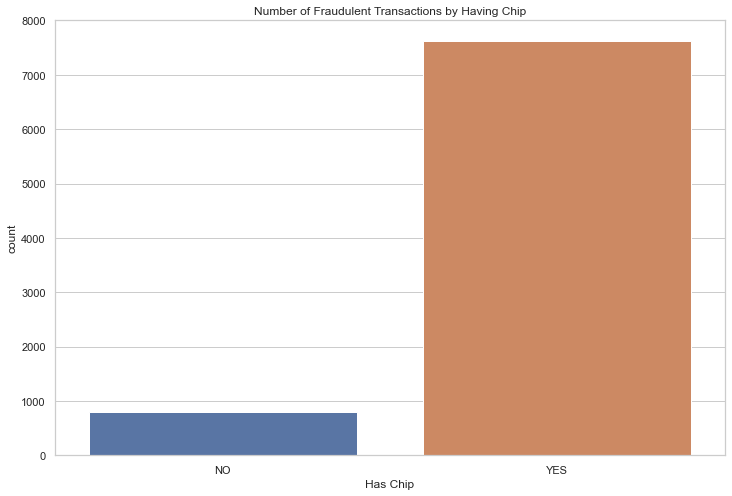

In [258]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Has Chip', order=sorted(fraud_data['Has Chip'].unique()))
plt.title('Number of Fraudulent Transactions by Having Chip')
plt.show()

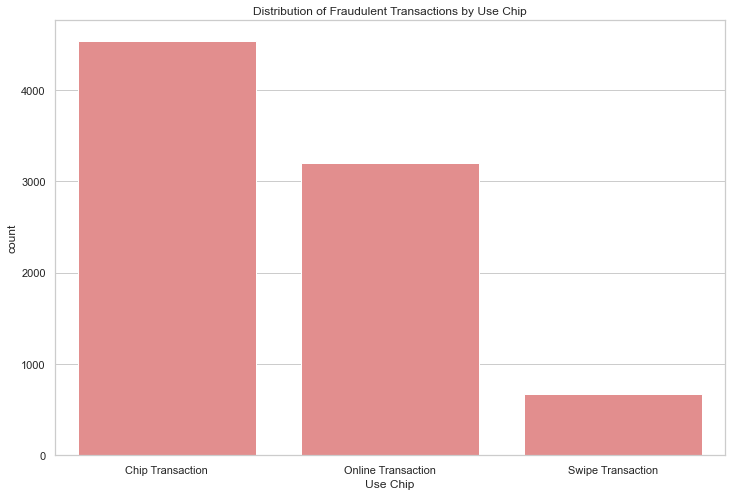

In [232]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Use Chip', color='lightcoral')
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()

Chip Transactions lead in fraudulent activity, followed by Online and Swipe Transactions, indicating chips are not deterring fraud as effectively as expected.

#### Transaction error

/var/folders/2r/yg0nprg96sbgd961y4crt5lm0000gq/T/ipykernel_57454/1353624752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_data["Errors?"]= fraud_data["Errors?"].fillna("No error")


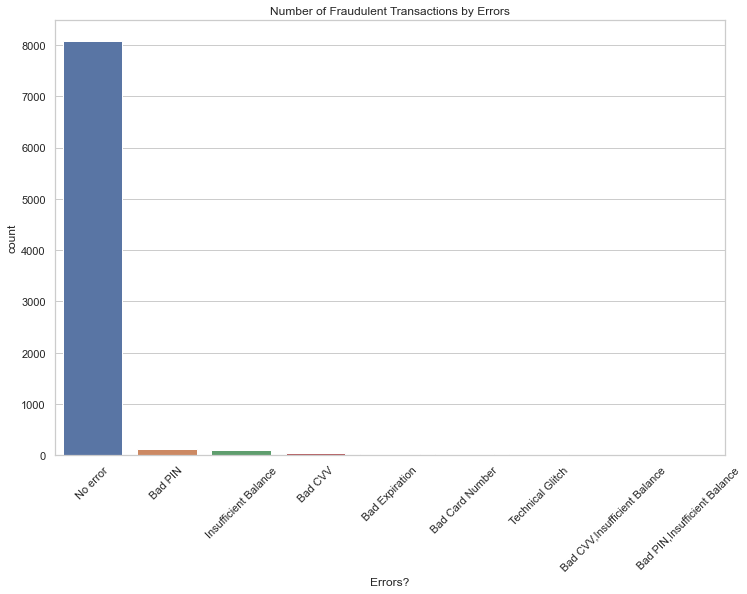

In [257]:
fraud_data["Errors?"]= fraud_data["Errors?"].fillna("No error")

# Calculate the order based on the count in descending order
order = fraud_data['Errors?'].value_counts().index

plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Errors?', order=order)
plt.title('Number of Fraudulent Transactions by Errors')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

The chart shows most fraudulent transactions occur without any errors being flagged, with 'No error' overwhelming other categories. Errors like 'Bad PIN' and 'Insufficient Balance' occur infrequently, suggesting fraud often goes undetected by typical error checks.

#### Card information

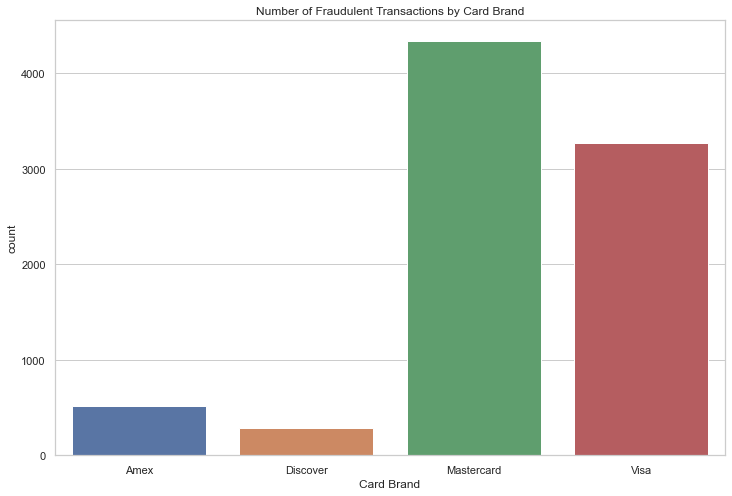

In [259]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Card Brand', order=sorted(fraud_data['Card Brand'].unique()))
plt.title('Number of Fraudulent Transactions by Card Brand')
plt.show()

The bar chart shows that Mastercard has the highest number of fraudulent transactions, followed by Visa, while Amex and Discover have significantly fewer instances of fraud.

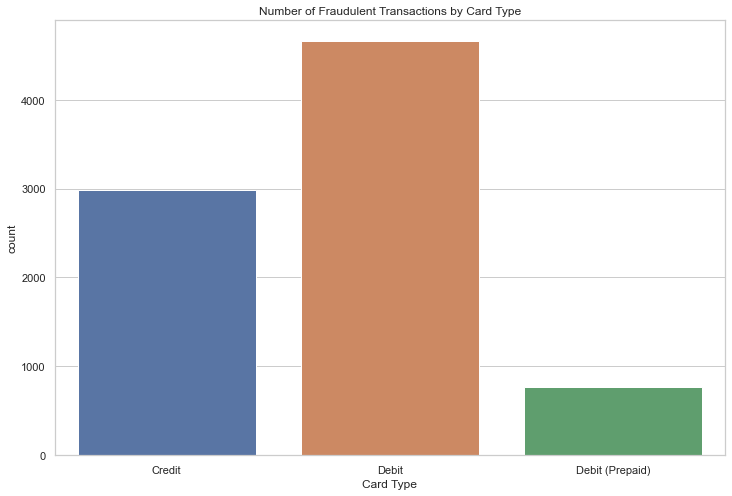

In [260]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Card Type', order=sorted(fraud_data['Card Type'].unique()))
plt.title('Number of Fraudulent Transactions by Card Type')
plt.show()

Debit cards experience the highest number of fraudulent transactions, surpassing credit cards, while prepaid debit cards show the fewest fraud cases.

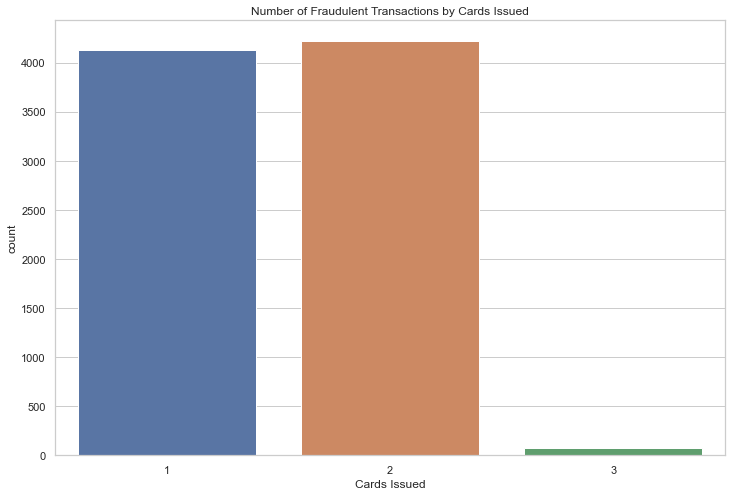

In [261]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Cards Issued', order=sorted(fraud_data['Cards Issued'].unique()))
plt.title('Number of Fraudulent Transactions by Cards Issued')
plt.show()

The bar chart indicates that accounts with two cards issued have the highest incidence of fraudulent transactions, followed closely by those with one card. Accounts with three cards issued see a significantly lower number of fraud cases.

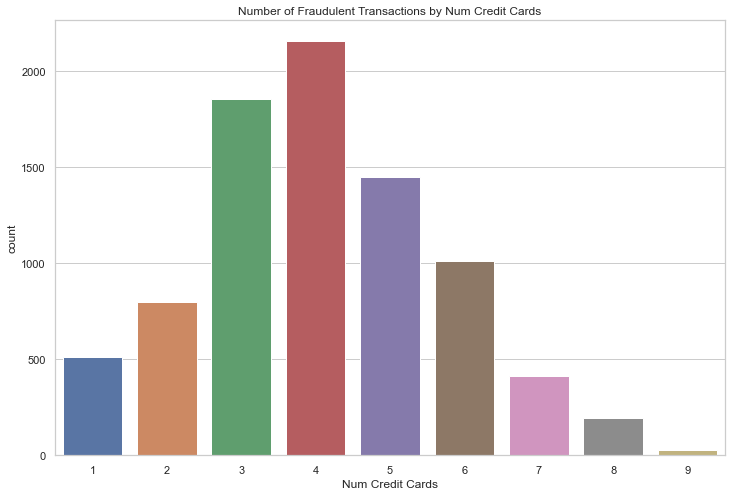

In [286]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Num Credit Cards', order=sorted(fraud_data['Num Credit Cards'].unique()))
plt.title('Number of Fraudulent Transactions by Num Credit Cards')
plt.show()

Individuals with three and four credit cards are most likely to experience fraud, with a noticeable decrease in fraud for those with more or fewer cards.

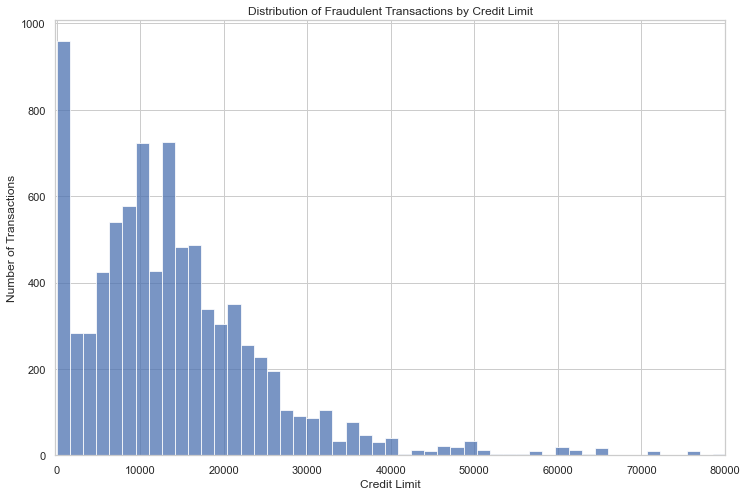

In [281]:
plt.figure(figsize=(12, 8))
sns.histplot(fraud_data['Credit Limit'].astype(float), bins=80, kde=False)
plt.title('Distribution of Fraudulent Transactions by Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 80000)
plt.show()

The histogram indicates that fraudulent transactions are more frequent at lower credit limits, with the highest occurrence around the 10,000 mark, and progressively decline as credit limits increase.

#### By Age

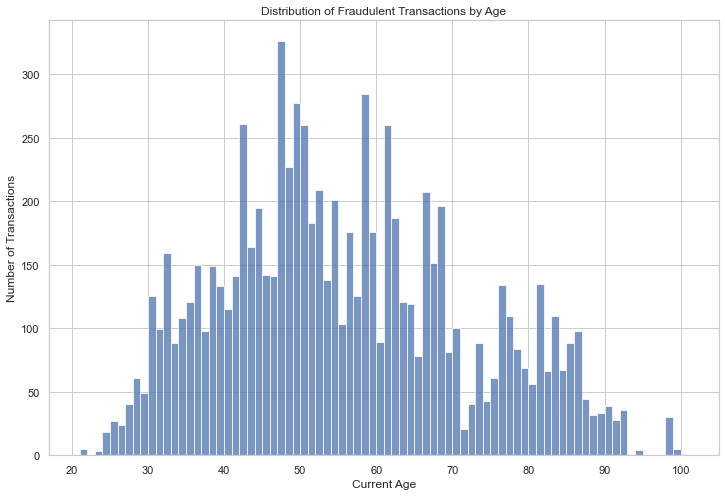

In [284]:
plt.figure(figsize=(12, 8))
sns.histplot(fraud_data['Current Age'].astype(float), bins=80, kde=False)
plt.title('Distribution of Fraudulent Transactions by Age')
plt.xlabel('Current Age')
plt.ylabel('Number of Transactions')
plt.show()

The histogram shows that fraudulent transactions are more prevalent among individuals in their 40s and 50s, with noticeable peaks around those ages, and tend to decrease among the older and younger age groups.

#### By Gender

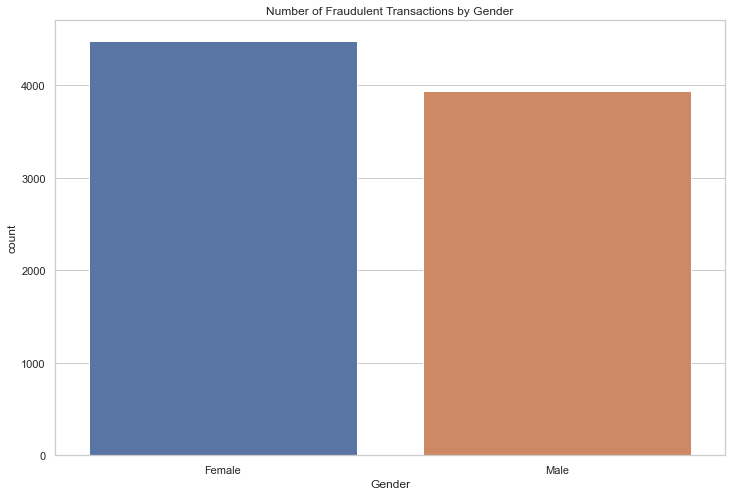

In [287]:
plt.figure(figsize=(12, 8))
sns.countplot(data=fraud_data, x='Gender', order=sorted(fraud_data['Gender'].unique()))
plt.title('Number of Fraudulent Transactions by Gender')
plt.show()

The bar chart indicates a roughly equal distribution of fraudulent transactions between female and male genders, with a slightly higher count for females.

## Fraud Detection with Machine Learning  <a class="anchor"  id="data_overview"></a>

### Data Preprocessing

In [294]:
# Remove the '?' from the name of columns in dataset
df.columns = [c.replace('?','') for c in df.columns]

#### Select features for predictive modeling based on EDA

Based on the EDA above, we will concentrate on variables that appear to exert a more significant impact on the likelihood of a case being fraudulent. Eliminating the variables with high percentage of missing value, we've chosen the following variables for modelling:

**<span style="color:#007d79;">Year, Day of Week, Hour, Amount, Has Chip, Use Chip, Merchant Name, Merchant City, MCC, Errors, Card Brand, Card Type, Cards Issued, Credit Limit, Current Age, Num Credit Cards.</span>** 

In [295]:
# Subset specific columns
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Has Chip','Use Chip', 'Merchant Name', 
                     'Merchant City','MCC', 'Is Fraud', 'Errors', 'Card Brand', 'Card Type','Cards Issued', 
                     'Credit Limit', 'Current Age', 'Num Credit Cards']
df = df[columns_to_select]

In [296]:
# Assuming df is your DataFrame
bins = [0, 10000, 20000, 30000, 50000, float('inf')]
labels = ['Under 10000', '10000 - 20000', '20000 - 30000', '30000 - 50000', 'Above 50000']

df['Credit Limit'] = pd.cut(df['Credit Limit'], bins=bins, labels=labels, right=False)

/var/folders/2r/yg0nprg96sbgd961y4crt5lm0000gq/T/ipykernel_57454/4247129268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Credit Limit'] = pd.cut(df['Credit Limit'], bins=bins, labels=labels, right=False)


#### Create pipeline to transform and optimize data features for the modeling process

In [305]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

def clean(df):
    # Convert data type
    df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
    
    # Scale the 'Amount' column
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
    
    # Handling the Errors column
    df['Errors'] = df['Errors'].apply(lambda x: 0 if x == 'No error' else 1)
   
    # Handling the 'Has Chip' column
    df['Has Chip'] = df['Has Chip'].map({'NO': 0, 'YES': 1})
    
    # Binary encoding for 'Use Chip', 'Day of Week' features
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    
    # Label encoding for 'Card Brand', 'Card Type', 'Merchant City', 'Merchant State' features
    label_encoder = LabelEncoder()
    df['Card Brand'] = label_encoder.fit_transform(df['Card Brand'])
    df['Card Type'] = label_encoder.fit_transform(df['Card Type'])
    df['Merchant City'] = label_encoder.fit_transform(df['Merchant City'])
    df['Credit Limit'] = label_encoder.fit_transform(df['Credit Limit'])

    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

/var/folders/2r/yg0nprg96sbgd961y4crt5lm0000gq/T/ipykernel_57454/893701075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
/var/folders/2r/yg0nprg96sbgd961y4crt5lm0000gq/T/ipykernel_57454/893701075.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Amount'] = scaler.fit_transform(df[['Amount']])
/var/folders/2r/yg0nprg96sbgd961y4crt5lm0000gq/T/ipykernel_57454/893701075.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=  23.4s


#### Implement Random Under Sampling to address the imbalance in dataset

Due to limitation of computational capacity, I subset 40000 data with 20% of them being fraud cases in order to balance the proportion and ensure model performance.

In [310]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud'])
y = df_transformed['Is Fraud']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

### Predictive Modeling with Random Forest <a class="anchor"  id="randomforest"></a>

In [311]:
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9608
         1.0       0.98      0.93      0.95      2392

    accuracy                           0.98     12000
   macro avg       0.98      0.96      0.97     12000
weighted avg       0.98      0.98      0.98     12000

[[9559   49]
 [ 169 2223]]


Overall, the Random Forest Classifier is performing very well in predicting both fraudulent and non-fraudulent transactions. The precision, recall, and F1-score are all high for both classes, indicating a robust model with high predictive power. The relatively low number of false positives and false negatives suggests that the model is reliable in distinguishing between fraudulent and non-fraudulent transactions. However, the slightly lower recall for fraudulent transactions (class 1) indicates there is still some room for improvement in capturing all actual fraud cases.

### Fine tuning Random Forest model

In [313]:
import warnings

# Suppress all warnings
warnings.simplefilter("ignore")

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' and kept 'sqrt'
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0, scoring='f1_macro') 

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9608
         1.0       0.98      0.94      0.96      2392

    accuracy                           0.98     12000
   macro avg       0.98      0.97      0.97     12000
weighted avg       0.98      0.98      0.98     12000

[[9565   43]
 [ 155 2237]]


**Summary**


* **Precision:** Both classes have high precision (0.98), indicating a low false positive rate.

* **Recall:**
  - For class 0 (non-fraud), recall is perfect at 1.00, meaning all non-fraudulent transactions were correctly identified.
  - For class 1 (fraud), recall has improved to 0.94 from 0.93, indicating better identification of fraudulent transactions.

* **F1-score:**
  - For class 0, it is excellent at 0.99.
  - For class 1, it's very good at 0.96, reflecting a balanced precision-recall trade-off for both classes.

* **Overall Accuracy:** Remains at 0.98, the same as before tuning.

* **Confusion Matrix:**
  - For class 0, the model correctly predicted 9565 out of 9608 non-fraudulent transactions (True Negatives) and incorrectly predicted 43 as fraudulent (False Positives).
  - For class 1, the model correctly predicted 2237 out of 2392 fraudulent transactions (True Positives), and 155 were missed and predicted as non-fraudulent (False Negatives).


### Test different prediction algorithms

In [327]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


# Define classifiers, including Random Forest
classifiers = {
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Naive Bayes": GaussianNB(),
    "CatBoost": CatBoostClassifier(verbose=0),  # 'verbose=0' to avoid printing every iteration
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Initialize list to store results
results = []

# Loop through classifiers, train, predict and store results
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Handle different label types in y_test
    label_0 = '0' if '0' in report else '0.0'
    label_1 = '1' if '1' in report else '1.0'
    
    # Store results in a dictionary
    result = {
        'Classifier': name,
        'Precision (Class 0)': report[label_0]['precision'],
        'Recall (Class 0)': report[label_0]['recall'],
        'F1-Score (Class 0)': report[label_0]['f1-score'],
        'Precision (Class 1)': report[label_1]['precision'],
        'Recall (Class 1)': report[label_1]['recall'],
        'F1-Score (Class 1)': report[label_1]['f1-score'],
        'Accuracy': report['accuracy'],
        'True Negative': conf_matrix[0][0],
        'False Positive': conf_matrix[0][1],
        'False Negative': conf_matrix[1][0],
        'True Positive': conf_matrix[1][1]
    }
    
    # Append results to the list
    results.append(result)

# Convert list of results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

,Classifier,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),Accuracy,True Negative,False Positive,False Negative,True Positive
0,LightGBM,0.989657,0.995837,0.992737,0.982847,0.958194,0.970364,0.988333,9568,40,100,2292
1,XGBoost,0.991298,0.995941,0.993614,0.983383,0.964883,0.974045,0.989750,9569,39,84,2308
2,Naive Bayes,0.800667,1.000000,0.889300,0.000000,0.000000,0.000000,0.800667,9608,0,2392,0
3,CatBoost,0.990175,0.996461,0.993308,0.985414,0.960284,0.972687,0.989250,9574,34,95,2297
4,Random Forest,0.982627,0.994900,0.988726,0.978433,0.929348,0.953259,0.981833,9559,49,169,2223


### Plot the result comparision of algorithm performances

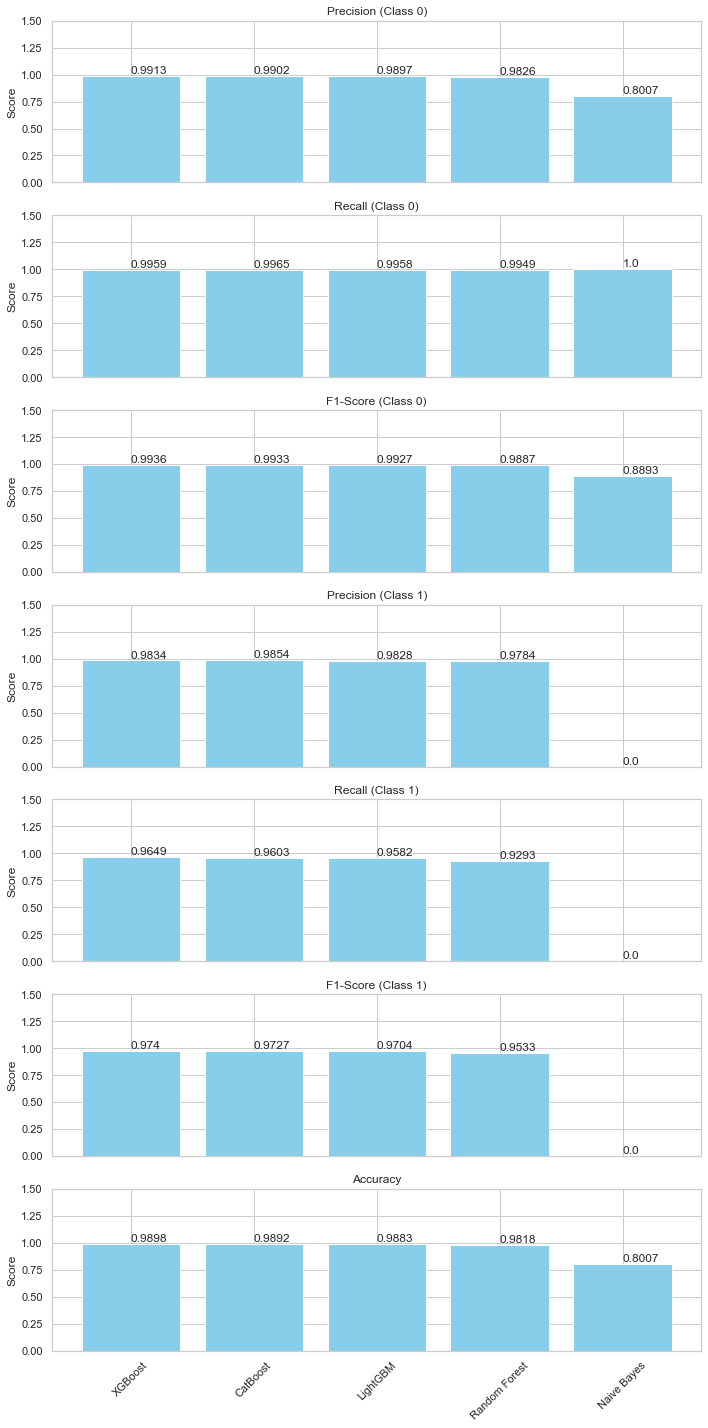

In [333]:
# Set up the matplotlib figure and axes
f, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=True)

# Set the bar plots for each metric
metrics = ['Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)', 
           'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)', 'Accuracy']
for i, metric in enumerate(metrics):
    sorted_df = results_df.sort_values(by=metric, ascending=False)
    bars = axes[i].bar(sorted_df['Classifier'], sorted_df[metric], color="skyblue")
    axes[i].set_title(metric)
    axes[i].set_ylabel('Score')
    
    # Set the y-axis limits
    axes[i].set_ylim(0, 1.5)  # Here we set the max y limit to 1.5
    
    # Add the text annotations on the bars
    for bar in bars:
        yval = bar.get_height()
        # Adjust text position based on the height.
        text_position = yval + 0.05 if yval < 1.45 else 1.45
        axes[i].text(bar.get_x() + bar.get_width()/2.0, text_position, round(yval, 4), va='center')  # va='center' to center the text

# Rotate the classifier names on x-axis for better readability
plt.xticks(rotation=45)
# Make sure that the x-ticks are not overlapping with each other
plt.tight_layout()

# Show the plot
plt.show()

**Based on the results**:

- Naive Bayes has very poor performance for Class 1, with zero precision and recall, likely due to the assumption of feature independence or data distribution not matching the algorithm's expectations. It's not a good candidate for further tuning in this context.

- Random Forest has decent scores across all metrics but is outperformed by other models, especially in detecting Class 1 (fraud).

- LightGBM shows strong performance, particularly with the highest F1-Score for Class 1, but is slightly lower in recall for Class 1 compared to XGBoost and CatBoost.

- XGBoost has the highest recall for Class 1, which is crucial for a fraud detection system to catch as many fraudulent transactions as possible.

- CatBoost also shows very strong performance and is comparable to XGBoost.

Given that XGBoost has the highest recall for Class 1 and the highest accuracy overall, it emerges as a top candidate for further tuning. Additionally, CatBoost is very close in performance and could also be considered for tuning, especially since it has the highest precision for Class 1.

### Tune XGBoost and CatBoost to see which can achieve better performance with optimization. 

In [328]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# XGBoost hyperparameter tuning
xgb_params = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5)
}

xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(xgb_classifier, param_distributions=xgb_params, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_random_search.fit(X_train, y_train)

# CatBoost hyperparameter tuning
cat_params = {
    'iterations': randint(100, 1000),
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(50, 200),
    'bagging_temperature': uniform(0.0, 1.0)
}

cat_classifier = CatBoostClassifier(verbose=0)
cat_random_search = RandomizedSearchCV(cat_classifier, param_distributions=cat_params, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
cat_random_search.fit(X_train, y_train)

# Output the best parameters and corresponding score
print(f"Best parameters for XGBoost: {xgb_random_search.best_params_}")
print(f"Best score for XGBoost: {xgb_random_search.best_score_}")
print(f"Best parameters for CatBoost: {cat_random_search.best_params_}")
print(f"Best score for CatBoost: {cat_random_search.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters for XGBoost: {'colsample_bytree': 0.960579738456838, 'gamma': 0.11179791925972632, 'learning_rate': 0.2989667618321834, 'max_depth': 6, 'n_estimators': 784, 'subsample': 0.9909636480122916}
Best score for XGBoost: 0.9877142601736525
Best parameters for CatBoost: {'bagging_temperature': 0.25416364906973876, 'border_count': 179, 'depth': 4, 'iterations': 884, 'l2_leaf_reg': 8, 'learning_rate': 0.21910472229858038}
Best score for CatBoost: 0.9880357002250829


- The best score for XGBoost: 0.9877
- The best score for CatBoost: 0.9880 (slightly higher)

Given these results, CatBoost has achieved a marginally better score in cross-validation and can be considered the better-performing algorithm for this particular task with the provided dataset and the hyperparameter space explored.

## Insights & Recommendations <a class="anchor"  id="insights"></a>

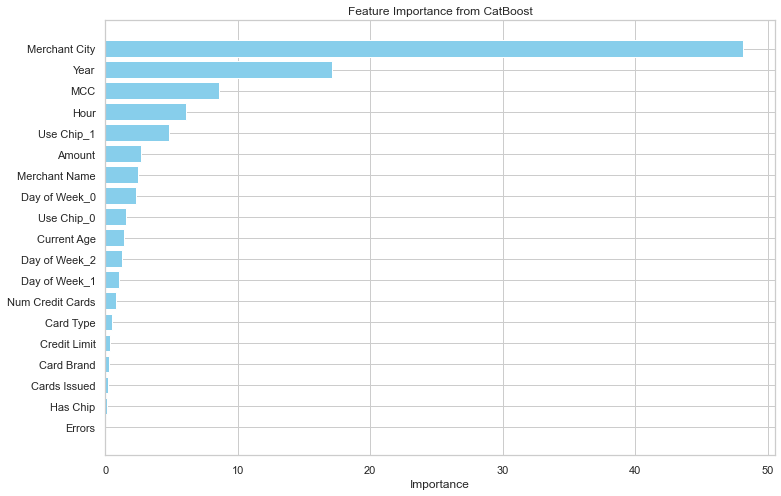

In [335]:
# Extract feature importances from the best Cat Boost model
feature_importances = catboost_classifier.get_feature_importance()
feature_names = X_train.columns
catboost_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
plt.barh(catboost_importances['Feature'], catboost_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from CatBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

### Insights 💡
Based on the feature importance scores, the top six most important features for predicting fraud transactions are:

**1. Merchant City**: This feature has the highest importance, indicating that the city where the merchant is located plays a significant role in predicting fraudulent transactions. This could suggest that fraud is more prevalent in certain cities, or that the model has identified patterns specific to certain locations.

**2. Year**: The year of the transaction is also a strong predictor, which could imply that fraud trends vary significantly over the years.

**3. MCC (Merchant Category Code)**: This suggests that the type of merchant (categorized by the code) is relevant to predicting fraud.
    
**4. Hour (Merchant Category Code)**: The time of day when the transaction occurred is also influential, which might mean that fraud happens more often during certain hours.
    
**5. Use Chip_1: Online transactions**:  online transactions might be more vulnerable compared to physical transactions like chip or swipe. This can be attributed to factors like phishing, weak password practices, or compromised databases.

**5. Amount**: The size of a transaction can be a significant indicator of its likelihood to be fraudulent. Fraudsters might either make very high-value transactions to maximize their gain from a stolen card before it's reported or make very small transactions to fly under the radar and test the card's validity. Therefore, unusually high or low amounts compared to a user's typical transaction patterns can be red flags.
    
These features have the highest impact on the model's ability to distinguish fraudulent transactions from non-fraudulent ones, which can help banks **<span style="color:#007d79;">prioritize their resources and efforts</span>** in fraud prevention. 

### Recommendations 📓

**1. For Merchant City:** 
- Implement enhanced monitoring and fraud detection measures in cities that are identified as high risk.
- Investigate transactions from these cities more closely, especially those that deviate from typical spending patterns.

**2. For Year:** 
- Conduct a deeper analysis of transactions based on the year to identify any emerging fraud trends.
- Strengthen security measures during specific times of the year when fraud is historically more prevalent.

**3. For MCC:** 
- Businesses and credit card companies should focus on increasing monitoring and protective measures for merchant categories that are identified as high risk for fraudulent activities. - - User education for these specific sectors might also be beneficial.

**4. For Hour:** 
- Increase real-time fraud monitoring during hours when fraudulent activity is most common.
- Alert customers to be more vigilant about transactions that occur during these high-risk hours.

**5. For Online Transactions:** 
- Encourage users to adopt secure online transaction practices, such as frequently updating passwords and avoiding transactions on public Wi-Fi.
- Raise awareness about phishing scams and the importance of ensuring websites are secure (e.g., HTTPS) before inputting card details.

**6. For Amount:** 
- Develop a dynamic thresholding system that flags unusually high or low transactions relative to a user's typical transaction profile. 
- Inform users when such anomalies occur.



